# Model C - Global Sum

El output es el conteo de conos. Se implemento una suma dentro de la red neuronal.

In [1]:
import os
import numpy as np
import imageio
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device_name = tf.test.gpu_device_name()
print("GPU detectada:", device_name)

GPU detectada: /device:GPU:0


In [4]:
# Rutas de los conjuntos de entrenamiento y validación
train_path = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Training+Density/'
val_path   = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Validation+Density/'

In [5]:
# Función para leer y preprocesar datos
def read_data(base_path, density_threshold=400):
    data = []
    anno = []
    file_list = os.listdir(base_path)
    for filename in file_list:
        if 'Density' in filename:
            base_filename = filename[:-11] + '.tif'
            img_path = os.path.join(base_path, base_filename)
            dens_path = os.path.join(base_path, filename)
            if os.path.exists(img_path) and os.path.exists(dens_path):
                # Cargar imagen y normalizar a [0,1]
                img = np.asarray(Image.open(img_path).convert("RGB")).astype(np.float32) / 255.0
                # Cargar mapa de densidad
                density = imageio.imread(dens_path).astype(np.float32)
                # Filtrado basado en la suma (ajustar el umbral según se requiera)
                if np.sum(density) / 100 < density_threshold:
                    data.append(img)
                    # Expandir la dimensión para que tenga forma (H, W, 1)
                    density = np.expand_dims(density, axis=-1)
                    anno.append(density)
    return np.array(data), np.array(anno)

In [6]:
# Cargar conjuntos de entrenamiento y validación
train_images, train_density_maps = read_data(train_path, density_threshold=400)
val_images, val_density_maps = read_data(val_path, density_threshold=400)

print("Train images shape:", train_images.shape)
print("Train density maps shape:", train_density_maps.shape)
print("Validation images shape:", val_images.shape)
print("Validation density maps shape:", val_density_maps.shape)

<ipython-input-5-342034160>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  density = imageio.imread(dens_path).astype(np.float32)


Train images shape: (184, 256, 256, 3)
Train density maps shape: (184, 256, 256, 1)
Validation images shape: (80, 256, 256, 3)
Validation density maps shape: (80, 256, 256, 1)


La suma de valores se hace con `if np.sum(np.sum(anno[i][:,:,0],0),0)/100`  
- Se asume que la anotación de la densidad de conos está almacenada en el primer canal.
- Se realiza una doble suma de los valores en este canal. -> Suma por fila y por columna.
- El resultado se divide entre 100 (normalización) para luego validar que es menor que 400.

In [7]:
# Cálculo de la cuenta (número de conos) por imagen
# Se usa np.sum sobre el primer canal directamente.
train_counts = [np.sum(dm[:, :, 0]) / 100 for dm in train_density_maps]
val_counts   = [np.sum(dm[:, :, 0]) / 100 for dm in val_density_maps]

# Convertir a arrays y darles forma (N, 1) para el modelo
train_counts = np.array(train_counts).reshape(-1, 1)
val_counts = np.array(val_counts).reshape(-1, 1)

In [8]:
# Función de data augmentation (flip y rotaciones)
def augment(image):
    # Flip horizontal aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
    # Flip vertical aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
    # Rotación aleatoria múltiplo de 90 grados
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    return image

# Crear datasets tf.data para entrenamiento y validación
batch_size = 8

# Dataset de entrenamiento: redimensionamiento, data augmentation y batching.
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_counts))
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, (256, 256)), y))
train_dataset = train_dataset.map(lambda x, y: (augment(x), y))
train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Dataset de validación: solo redimensionamiento y batching.
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_counts))
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, (256,256)), y))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
# Construcción del modelo U-Net mejorado
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

# Entrada del modelo
inputs = layers.Input(shape=(256,256,3))

# Encoder
c1, p1 = encoder_block(inputs, 16)
c2, p2 = encoder_block(p1, 32)
c3, p3 = encoder_block(p2, 64)

# Cuello de botella con Dropout para regularización
b = conv_block(p3, 128)
b = layers.Dropout(0.5)(b)

# Decoder
def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x

d1 = decoder_block(b, c3, 64)
d2 = decoder_block(d1, c2, 32)
d3 = decoder_block(d2, c1, 16)

# Mapa de densidad: activación ReLU para evitar valores negativos
density_map = layers.Conv2D(1, (1, 1), activation='relu')(d3)

# Nuevas capas para obtener la cuenta total a partir del mapa de densidad
# Se realiza una suma global sobre cada imagen
sum_outputs = layers.Lambda(lambda x: tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True),
                            name='global_sum')(density_map)
flattened = layers.Flatten()(sum_outputs)
final_output = layers.Dense(1, activation=None, name='final_regression')(flattened)

# Definir el modelo con la salida final de regresión (conteo de conos)
model = models.Model(inputs=inputs, outputs=final_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 538,611 (2.05 MB)

 Trainable params: 537,203 (2.05 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [10]:
# Compilar el modelo
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=['mae'])

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6)
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo usando el pipeline de tf.data
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    callbacks=[early_stop, reduce_lr, checkpoint])


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 87090576.0000 - mae: 6289.4058

23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 165ms/step - loss: 84581848.0000 - mae: 6134.2573 - val_loss: 145581.7500 - val_mae: 360.1830 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - loss: 78725.6953 - mae: 268.7352 - val_loss: 884916.3750 - val_mae: 829.0903 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 45597.3984 - mae: 201.2671

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 45350.6406 - mae: 200.7239 - val_loss: 61018.7266 - val_mae: 216.8195 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 34580.7734 - mae: 174.5803

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 34584.9961 - mae: 174.5656 - val_loss: 20285.3711 - val_mae: 130.1798 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 32641.6621 - mae: 170.5359

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 32600.6836 - mae: 170.3323 - val_loss: 17113.7891 - val_mae: 118.1905 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 31459.5566 - mae: 165.3783

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 31393.2012 - mae: 165.1577 - val_loss: 16633.7852 - val_mae: 116.0375 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 27393.7539 - mae: 155.3229

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 27417.8203 - mae: 155.3014 - val_loss: 16619.8477 - val_mae: 115.9707 - learning_rate: 0.0010
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 25552.6152 - mae: 147.1915 - val_loss: 16834.6445 - val_mae: 116.9572 - learning_rate: 0.0010
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 26758.7910 - mae: 151.5595 - val_loss: 17341.1445 - val_mae: 119.1689 - learning_rate: 0.0010
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 26255.9688 - mae: 149.2391 - val_loss: 18266.3965 - val_mae: 122.8968 - learning_rate: 0.0010
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 24987.5449 - mae: 147.2885 - val_loss: 19855.4355 - val_mae: 128.8020 - learning_rate: 0.0010
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 26171.4512 - mae: 148.7442 - val_loss: 22359.7461 - val_mae: 137.4842 - learning_rate: 0.0010
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 21383.8477 - mae: 134.4

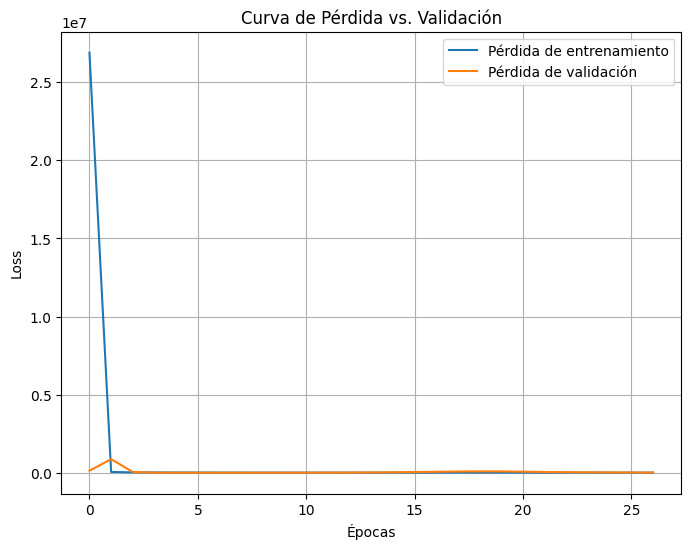

In [11]:
# Visualización de la curva de entrenamiento
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Pérdida vs. Validación')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Evaluación del modelo
model.load_weights('ModelC.h5')
val_loss, val_mae = model.evaluate(val_dataset)
print(f"Validación - MSE: {val_loss:.3f}, MAE: {val_mae:.3f}")

# Predicción y visualización de resultados en un ejemplo de validación
# Se toma un batch y se selecciona la segunda imagen del batch (índice 1)
for test_imgs, true_counts_batch in val_dataset.take(1):
    test_img_sample = test_imgs[1]
    true_count_sample = true_counts_batch[1]

# Dado que el modelo devuelve un valor escalar (conteo), se predice directamente
predicted_count = model.predict(tf.expand_dims(test_img_sample, axis=0)).squeeze()

# Convertir a escalar si es necesario
true_count_scalar = true_count_sample.item() if hasattr(true_count_sample, 'item') else true_count_sample
predicted_count_scalar = predicted_count.item() if hasattr(predicted_count, 'item') else predicted_count

true_count_scalar, predicted_count_scalar

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2563.6731 - mae: 41.6270
Validación - MSE: 2470.844, MAE: 38.845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([54.], dtype=float32)>,
 110.54402923583984)

In [19]:
true_count_val = float(true_count_sample.numpy()[0])
predicted_count_val = float(predicted_count)
print(f"Conteo real: {true_count_val:.2f} | Conteo predicho: {predicted_count_val:.2f}")

Conteo real: 54.00 | Conteo predicho: 110.54


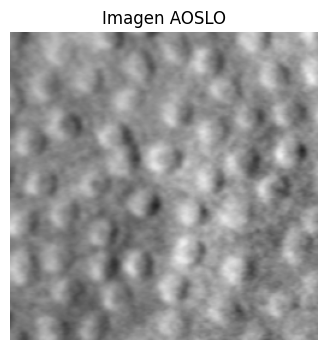

In [20]:
# Visualización: se muestran la imagen de entrada y los resultados en un panel
plt.figure(figsize=(12,4))

plt.subplot(1,1,1)
plt.imshow(test_img_sample)
plt.title("Imagen AOSLO")
plt.axis('off')

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
After training, the difference is : 38.84538650512695 cells per image.


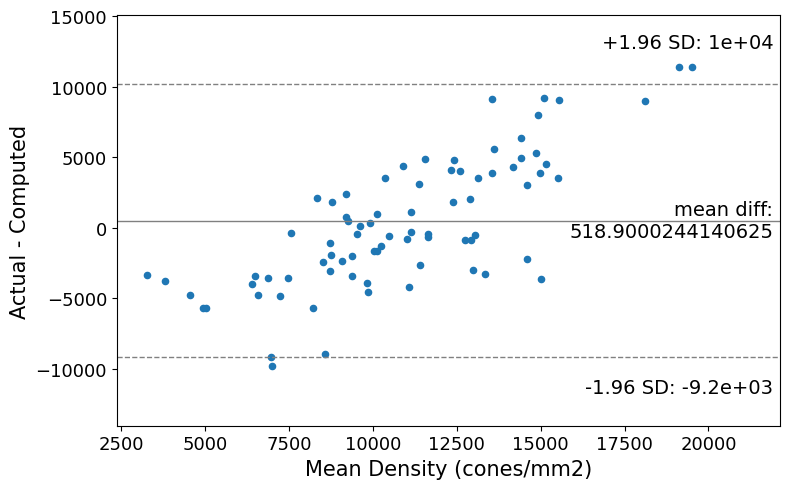

          True        Pred
0    84.000000  103.707832
1    54.000004  110.544029
2    76.000008  121.318565
3   149.000000  113.878891
4    24.000002  115.515854
..         ...         ...
75  133.000015  114.588425
76  139.000000  118.867455
77  129.000000   98.281754
78   97.000000   78.897942
79   82.000008   92.685410

[80 rows x 2 columns]


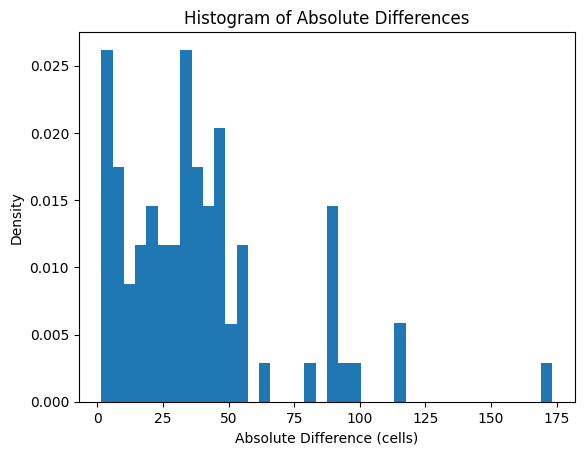

In [21]:
val_counts = []
for i in range(len(val_density_maps)):
    val_counts.append(np.sum(np.sum(val_density_maps[i][:,:,0],0),0)/100)

true_counts=val_counts

# Get the model predictions (which are now scalars) and flatten the result.
model_prediction = model.predict(val_dataset).flatten()

# Compute the average absolute difference.
mean_diff = np.mean(np.abs(model_prediction - true_counts))
print('After training, the difference is : {} cells per image.'.format(mean_diff))

## fix scale
true_raw = np.array(true_counts) * 100
pred_raw  = model_prediction        * 100

# For plotting a mean-difference plot using statsmodels:
import statsmodels.api as sm
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(8,5))
sm.graphics.mean_diff_plot(true_raw, pred_raw, ax=ax)
plt.ylabel('Actual - Computed')
plt.xlabel('Mean Density (cones/mm2)')
plt.show()

# You can also create a dataframe for further analysis:
import pandas as pd
df = pd.DataFrame({'True': true_counts, 'Pred': model_prediction})
print(df)

# And plot a histogram of differences:
differences = np.abs(true_counts - model_prediction)
plt.figure()
plt.hist(differences, density=True, bins=40)
plt.title("Histogram of Absolute Differences")
plt.xlabel("Absolute Difference (cells)")
plt.ylabel("Density")
plt.show()

In [22]:
from sklearn.metrics import r2_score

y_true, y_pred = [], []

# Recorremos todo el validation set sin alterar el grafo
for batch_x, batch_y in val_dataset:
    preds = model(batch_x, training=False)
    y_true.append(batch_y.numpy().ravel())
    y_pred.append(preds.numpy().ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Métricas
mae  = np.mean(np.abs(y_true - y_pred))
mse  = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2   = r2_score(y_true, y_pred)
corr = np.corrcoef(y_true, y_pred)[0,1]

print(f"MAE : {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f} %")
print(f"R²  : {r2:.3f}")
print(f"ρ   : {corr:.3f}")

MAE : 38.845
MSE: 2470.843
RMSE: 49.708
MAPE: 55.29 %
R²  : 0.238
ρ   : 0.514


In [23]:
import numpy as np

# Assuming true_counts and model_prediction are already available from your code
# Normalized scale
true_counts = np.array(true_counts)
model_prediction = np.array(model_prediction)

# MAE (already computed in your code as mean_diff)
mae = np.mean(np.abs(model_prediction - true_counts))

# MSE
mse = np.mean((model_prediction - true_counts) ** 2)

# RMSE
rmse = np.sqrt(mse)

# MAPE (handle division by zero by adding a small epsilon or filtering)
epsilon = 1e-10  # Small value to avoid division by zero
mape = np.mean(np.abs((model_prediction - true_counts) / (true_counts + epsilon))) * 100

print("Normalized Scale (counts / 100):")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}%")

# Raw scale (multiply by 100)
true_raw = true_counts * 100
pred_raw = model_prediction * 100

# MAE (raw)
mae_raw = np.mean(np.abs(pred_raw - true_raw))

# MSE (raw)
mse_raw = np.mean((pred_raw - true_raw) ** 2)

# RMSE (raw)
rmse_raw = np.sqrt(mse_raw)

# MAPE (raw)
mape_raw = np.mean(np.abs((pred_raw - true_raw) / (true_raw + epsilon))) * 100

print("\nRaw Scale (counts):")
print(f"MAE: {mae_raw:.3f}")
print(f"MSE: {mse_raw:.3f}")
print(f"RMSE: {rmse_raw:.3f}")
print(f"MAPE: {mape_raw:.3f}%")

Normalized Scale (counts / 100):
MAE: 38.845
MSE: 2470.842
RMSE: 49.708
MAPE: 55.287%

Raw Scale (counts):
MAE: 3884.538
MSE: 24708422.000
RMSE: 4970.757
MAPE: 55.287%
